In [26]:
import pickle as pkl
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')


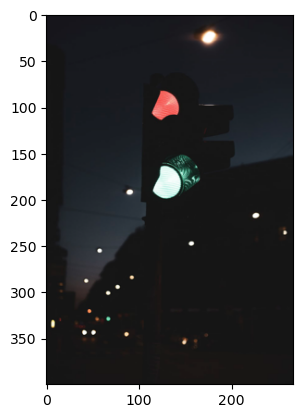

In [3]:
with open('images.pkl', 'rb') as f:
    images = pkl.load(f)

plt.imshow(images[0])

In [4]:
with open('target.pkl', 'rb') as f:
    labels = pkl.load(f)

print(labels[0])

trafficlight


In [28]:
sizes_df = pd.DataFrame([[img, img.shape[0], img.shape[1]] for img in images], columns=['image','height', 'width'])
sizes_df['label'] = labels
sizes_df.head()

,image,height,width,label
0,"[[[22, 21, 27], [22, 21, 27], [22, 21, 27], [2...",400,267,trafficlight
1,"[[[178, 191, 212], [178, 191, 212], [178, 192,...",283,400,trafficlight
2,"[[[201, 217, 230], [201, 217, 230], [202, 217,...",400,306,trafficlight
3,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...",300,400,trafficlight
4,"[[[197, 212, 223], [197, 211, 223], [197, 210,...",400,267,trafficlight


In [29]:
sizes_df.groupby('label').count()

,image,height,width
label,,,
crosswalk,88,88,88
speedlimit,652,652,652
stop,76,76,76
trafficlight,61,61,61


In [30]:
# Randomly drop 552 rows from the dataset that have the label 'speedlimit'
speedlimit_df = sizes_df[sizes_df['label'] == 'speedlimit']
speedlimit_df = speedlimit_df.sample(frac=1, random_state=27).reset_index(drop=True)
speedlimit_df = speedlimit_df.iloc[552:]
sizes_df = sizes_df[sizes_df['label'] != 'speedlimit']
sizes_df = pd.concat([sizes_df, speedlimit_df])
sizes_df.groupby('label').count()

,image,height,width
label,,,
crosswalk,88,88,88
speedlimit,100,100,100
stop,76,76,76
trafficlight,61,61,61


In [31]:
sizes_df.groupby('label')['height'].value_counts()

label         height
crosswalk     400       60
              267        6
              300        3
              225        2
              228        2
              166        1
              222        1
              227        1
              235        1
              244        1
              247        1
              252        1
              265        1
              266        1
              269        1
              273        1
              281        1
              293        1
              302        1
              337        1
speedlimit    400       93
              225        3
              267        2
              200        1
              364        1
stop          400       46
              301       11
              267       10
              269        3
              242        1
              266        1
              270        1
              272        1
              273        1
              290        1
trafficlight  400       43
       

In [32]:
sizes_df.groupby('label')['height'].mean().mean()

365.071469232881

In [33]:
sizes_df.groupby('label')['width'].mean().mean()

324.7209192877873

In [46]:
images = np.array(sizes_df['image'])
labels = sizes_df['label'].tolist()

In [47]:
images[0].shape

(400, 267, 3)

In [48]:
target_size = (324, 365)

cv2.resize(images[0], (324, 365)).shape

(365, 324, 3)

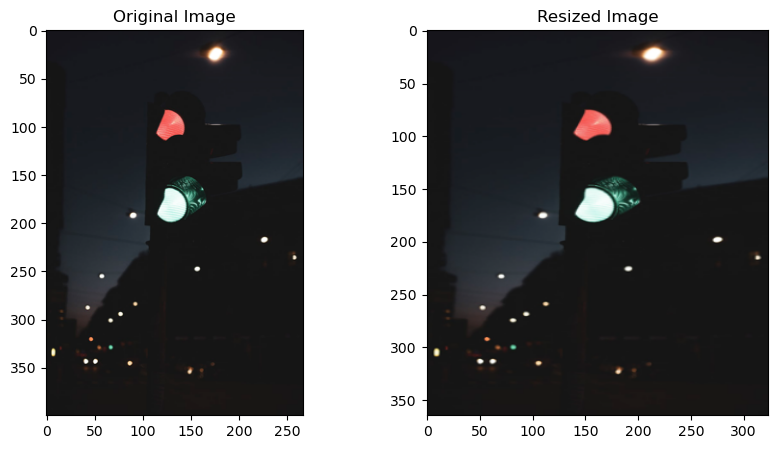

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(images[0])
axes[0].set_title('Original Image')
axes[1].imshow(cv2.resize(images[0], (324, 365)))
axes[1].set_title('Resized Image')
plt.show()

In [50]:
resized_images = [cv2.resize(img, target_size) for img in images]
sizes = set([img.shape for img in resized_images])
print(sizes)

{(365, 324, 3)}


In [51]:
resized_images[0]

array([[[22, 21, 27],
        [22, 21, 27],
        [22, 21, 27],
        ...,
        [22, 21, 27],
        [22, 21, 27],
        [22, 21, 27]],

       [[22, 21, 27],
        [22, 21, 27],
        [22, 21, 27],
        ...,
        [22, 21, 27],
        [22, 21, 27],
        [22, 21, 27]],

       [[22, 21, 27],
        [22, 21, 27],
        [22, 21, 27],
        ...,
        [22, 21, 27],
        [22, 21, 27],
        [22, 21, 27]],

       ...,

       [[21, 21, 21],
        [21, 21, 21],
        [21, 21, 21],
        ...,
        [21, 21, 21],
        [21, 21, 21],
        [21, 21, 21]],

       [[21, 21, 21],
        [21, 21, 21],
        [21, 21, 21],
        ...,
        [21, 21, 21],
        [21, 21, 21],
        [21, 21, 21]],

       [[21, 21, 21],
        [21, 21, 21],
        [21, 21, 21],
        ...,
        [21, 21, 21],
        [21, 21, 21],
        [21, 21, 21]]], dtype=uint8)

In [52]:
# Convert all images to floating point numpy arrays
float_images = [np.array(img).astype(np.float32) for img in resized_images]
float_images[0]

array([[[22., 21., 27.],
        [22., 21., 27.],
        [22., 21., 27.],
        ...,
        [22., 21., 27.],
        [22., 21., 27.],
        [22., 21., 27.]],

       [[22., 21., 27.],
        [22., 21., 27.],
        [22., 21., 27.],
        ...,
        [22., 21., 27.],
        [22., 21., 27.],
        [22., 21., 27.]],

       [[22., 21., 27.],
        [22., 21., 27.],
        [22., 21., 27.],
        ...,
        [22., 21., 27.],
        [22., 21., 27.],
        [22., 21., 27.]],

       ...,

       [[21., 21., 21.],
        [21., 21., 21.],
        [21., 21., 21.],
        ...,
        [21., 21., 21.],
        [21., 21., 21.],
        [21., 21., 21.]],

       [[21., 21., 21.],
        [21., 21., 21.],
        [21., 21., 21.],
        ...,
        [21., 21., 21.],
        [21., 21., 21.],
        [21., 21., 21.]],

       [[21., 21., 21.],
        [21., 21., 21.],
        [21., 21., 21.],
        ...,
        [21., 21., 21.],
        [21., 21., 21.],
        [21., 21., 21.]]

In [53]:
# Normalize images to a range between 0 and 1 by dividing all pixel values by the max of 255
normalized_images = [img/255 for img in float_images]
normalized_images[0]

array([[[0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        ...,
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235]],

       [[0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        ...,
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235]],

       [[0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        ...,
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235]],

       ...,

       [[0.08235294, 0.08235294, 0.08235294],
        [0.08235294, 0.08235294, 0.08235294],
        [0.08235294, 0

In [54]:
X = np.array(normalized_images)
X[0]

array([[[0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        ...,
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235]],

       [[0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        ...,
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235]],

       [[0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        ...,
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235],
        [0.08627451, 0.08235294, 0.10588235]],

       ...,

       [[0.08235294, 0.08235294, 0.08235294],
        [0.08235294, 0.08235294, 0.08235294],
        [0.08235294, 0

In [55]:
y_label_encoder = LabelEncoder()
y_label_encoder.fit(labels)
y = y_label_encoder.transform(labels)
y[:100]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [56]:
list(y_label_encoder.classes_)

['crosswalk', 'speedlimit', 'stop', 'trafficlight']

In [57]:
# Get the count of each value in y
unique, counts = np.unique(y, return_counts=True) 
print(np.asarray((unique, counts)).T)

[[  0  88]
 [  1 100]
 [  2  76]
 [  3  61]]


In [58]:
# Split the training dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),     # Random rotation (10 degrees)
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Random horizontal and vertical shift
    tf.keras.layers.RandomZoom(0.1),             # Random zoom
    tf.keras.layers.RandomContrast(0.1),         # Random contrast 
])

In [60]:
# Create an empty list for X and y augmentations
X_train_aug = []
y_train_aug = []

# Loop through the entire X_train set
for i in range(len(X_train)):
    # Select the original image and its y label
    img = X_train[i]
    label = y_train[i]
   
    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # If the label is not 1 (i.e. not a speedlimit), augment the image
    if label != 1:
        # Add 8 new images for every original
        for j in range(5):
            # Create and append the image
            X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
            # Append the original label
            y_train_aug.append(label)
    else:
        # Append the original image and label
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        y_train_aug.append(label)

# Print the length of the augmented images and the labels
print(len(X_train_aug))
print(len(y_train_aug))

976
976


In [61]:
# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

In [62]:
# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)

In [64]:
# Print the total number of one_hot_encoded columns
np.array(y_train_aug_np).shape

(976, 4)

In [65]:
# Create a dictionary to store the train/test data
data = {
    'X_train': X_train_aug_np,
    'X_test': X_test_np,
    'y_train': y_train_aug_np,
    'y_test': y_test_np
}

# Save the dictionary to a pickle file
with open('signs_dict.pkl', 'wb') as f:
    pkl.dump(data, f)

In [198]:
# Load the dictionary from the pickle file
with open('signs_dict.pkl', 'rb') as f:
    data = pkl.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


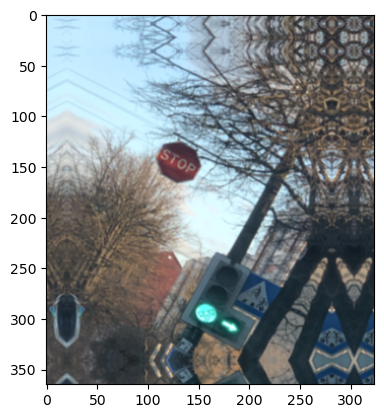

In [67]:
plt.imshow(data['X_train'][900])

In [68]:
X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
y_train = np.array(data['y_train'])
y_test = np.array(data['y_test'])

In [69]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(976, 4)
(976, 365, 324, 3)
(65, 4)
(65, 365, 324, 3)


In [76]:
# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(365, 324, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 classes
])

In [77]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 363, 322, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 181, 161, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 179, 159, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 89, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 77, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 214368)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │     6,859,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,889,444 (26.28 MB)

 Trainable params: 6,889,444 (26.28 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 32
epochs = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 547ms/step - accuracy: 0.2757 - loss: 1.9769 - val_accuracy: 0.3077 - val_loss: 1.3869
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 550ms/step - accuracy: 0.3244 - loss: 1.3784 - val_accuracy: 0.2308 - val_loss: 1.3886
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.3692 - loss: 1.3710 - val_accuracy: 0.2308 - val_loss: 1.3907
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 541ms/step - accuracy: 0.3611 - loss: 1.3646 - val_accuracy: 0.2308 - val_loss: 1.3928
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.3909 - loss: 1.3580 - val_accuracy: 0.2308 - val_loss: 1.3956
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 546ms/step - accuracy: 0.3784 - loss: 1.3519 - val_accuracy: 0.2308 - val_loss: 1.3983
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 549ms/step - accuracy: 0.4029 - loss: 1.3408 - val_accuracy: 0.2308 - val_loss: 1.4010
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 540ms/step - accuracy: 0.3856 - loss: 1.3402 - val_accu

In [80]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2560 - loss: 1.4107 


[1.4112027883529663, 0.23076923191547394]

In [81]:
# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(365, 324, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='sigmoid')  # 4 classes
])

In [82]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
# Train the model
batch_size = 25
epochs = 20
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step - accuracy: 0.3200 - loss: 1.6028 - val_accuracy: 0.3692 - val_loss: 1.1957
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.6380 - loss: 0.9396 - val_accuracy: 0.5385 - val_loss: 1.0488
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - accuracy: 0.8292 - loss: 0.5666 - val_accuracy: 0.4769 - val_loss: 1.1180
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.9118 - loss: 0.3339 - val_accuracy: 0.5692 - val_loss: 1.7555
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.9178 - loss: 0.2916 - val_accuracy: 0.4615 - val_loss: 1.8515
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - accuracy: 0.9651 - loss: 0.1242 - val_accuracy: 0.5385 - val_loss: 1.9069
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.9948 - loss: 0.0402 - val_accuracy: 0.5231 - val_loss: 2.5058
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.9977 - loss: 0.0136 - val_accu

In [84]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5544 - loss: 3.6313


[3.8502724170684814, 0.5384615659713745]

In [88]:
# Define the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(365, 324, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(4, activation='softmax')  # 4 classes
])

In [89]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [90]:
# Train the model
batch_size = 32
epochs = 50
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - accuracy: 0.3745 - loss: 2.6735 - val_accuracy: 0.4462 - val_loss: 1.2082
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step - accuracy: 0.5756 - loss: 1.0195 - val_accuracy: 0.4462 - val_loss: 1.3061
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 599ms/step - accuracy: 0.6392 - loss: 0.8692 - val_accuracy: 0.4615 - val_loss: 1.1101
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 606ms/step - accuracy: 0.7159 - loss: 0.7411 - val_accuracy: 0.5077 - val_loss: 1.1732
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.7984 - loss: 0.5823 - val_accuracy: 0.5077 - val_loss: 1.1350
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.8291 - loss: 0.5173 - val_accuracy: 0.4769 - val_loss: 1.6243
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 582ms/step - accuracy: 0.8587 - loss: 0.4432 - val_accuracy: 0.5385 - val_loss: 1.6161
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 582ms/step - accuracy: 0.9219 - loss: 0.2770 - val_accu

In [91]:
# Print classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=['crosswalk', 'speedlimit', 'stop', 'trafficlight']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
              precision    recall  f1-score   support

   crosswalk       0.43      0.87      0.58        15
  speedlimit       1.00      0.11      0.19        19
        stop       0.67      0.70      0.68        20
trafficlight       0.58      0.64      0.61        11

    accuracy                           0.55        65
   macro avg       0.67      0.58      0.51        65
weighted avg       0.70      0.55      0.50        65



In [93]:
# Load the data
with open('signs_dict.pkl', 'rb') as f:
    data = pkl.load(f)

X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
y_train = np.array(data['y_train'])
y_test = np.array(data['y_test'])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Define the model
model = keras.Sequential([
    layers.Input(shape=(365, 324, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - accuracy: 0.3766 - loss: 1.8873 - val_accuracy: 0.4462 - val_loss: 1.1821
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.6098 - loss: 0.9578 - val_accuracy: 0.4615 - val_loss: 1.2540
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.6744 - loss: 0.8270 - val_accuracy: 0.5231 - val_loss: 1.0690
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 661ms/step - accuracy: 0.7344 - loss: 0.7076 - val_accuracy: 0.4923 - val_loss: 1.4063
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 657ms/step - accuracy: 0.7405 - loss: 0.7321 - val_accuracy: 0.6154 - val_loss: 1.0214
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 661ms/step - accuracy: 0.7817 - loss: 0.6165 - val_accuracy: 0.5231 - val_loss: 1.3653
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 665ms/step - accuracy: 0.7808 - loss: 0.5828 - val_accuracy: 0.5846 - val_loss: 1.0800
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 661ms/step - accuracy: 0.7780 - loss: 0.5858 - val_accu

In [94]:
# Print classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=['crosswalk', 'speedlimit', 'stop', 'trafficlight']))

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C94BD52D40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
              precision    recall  f1-score   support

   crosswalk       0.67      0.80      0.73        15
  speedlimit       0.76      0.68      0.72        19
        stop       0.94      0.85 